# Experiments analysis

In [1]:
import msgpack
import edge_sim_py
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.ticker as mtick
import scipy.stats as stats

pd.options.display.max_colwidth = 200

## Base functions

### Latency

In [2]:
def get_latency_data(user_type=None):
    user_data = []

    for log in logs:
        simulation_data = {
            "dataset": log,
            "mean": 0,
            "median": 0,
            "p95": 0,
            "geo_mean": 0,
        }

        # Opening file
        user_msgpack_file = (
            f"{base_dir}/algorithm={log[0]};dataset={log[1]};seed={seed}/User.msgpack"
            if len (log) == 2
            else f"{base_dir}/algorithm={log[0]};dataset={log[1]};seed={seed};replicas={log[2]};percentage={log[3]}/User.msgpack"
        )
        user_file = open(user_msgpack_file, "rb")
        user_msgpack = msgpack.load(user_file)
        user_df = pd.DataFrame(user_msgpack)

        # Collecting information
        latency = (
            user_df[["Object", "Delays"]]
            if user_type is None
            else user_df[user_df["User Type"] == user_type][["Object", "Delays"]]
        )

        # Persisting information
        simulation_data["mean"] = latency["Delays"].mean()
        simulation_data["median"] = latency["Delays"].median()
        simulation_data["p95"] = latency["Delays"].quantile(0.95)
        simulation_data["geo_mean"] = stats.gmean(latency["Delays"])

        # Closing file
        user_file.close()

        # Appending data
        user_data.append(simulation_data)

    return pd.DataFrame(user_data)

### Provisioning Time

In [3]:
def get_provisioning_time_data(step):
    service_data = []

    for log in logs:
        simulation_data = {
            "dataset": log,
            "mean": 0,
            "median": 0,
            "p95": 0,
            "mean (w/o cache)": 0,
            "geo_mean (w/o cache)": 0,
            "old_mean": 0,
        }

        # Opening file
        service_msgpack_file = (
            f"{base_dir}/algorithm={log[0]};dataset={log[1]};seed={seed}/Service.msgpack"
            if len (log) == 2
            else f"{base_dir}/algorithm={log[0]};dataset={log[1]};seed={seed};replicas={log[2]};percentage={log[3]}/Service.msgpack"
        )
        service_file = open(service_msgpack_file, "rb")
        service_msgpack = msgpack.load(service_file)
        service_df = pd.DataFrame(service_msgpack)

        # Collecting information
        migrations_duration = service_df[service_df["Time Step"] == step]["Migrations Duration"].apply(pd.Series).stack().reset_index(drop=True)
        migrations_without_cache_duration = service_df[service_df["Time Step"] == step]["Migrations Without Cache Duration"].apply(pd.Series).stack().reset_index(drop=True)
        mean_migration_duration = service_df[service_df["Time Step"] == step]["Migrations Duration"].apply(lambda x: sum(x) / len(x) if len(x) > 0 else 0)

        # Persisting information
        simulation_data["mean"] = migrations_duration.mean()
        simulation_data["median"] = migrations_duration.median()
        simulation_data["p95"] = migrations_duration.quantile(0.95)
        simulation_data["mean (w/o cache)"] = migrations_without_cache_duration.mean()
        simulation_data["geo_mean (w/o cache)"] = stats.gmean(migrations_without_cache_duration)
        simulation_data["old_mean"] = mean_migration_duration.mean()

        # Closing file
        service_file.close()

        # Appending data
        service_data.append(simulation_data)

    return pd.DataFrame(service_data)

### Service Reallocations

In [4]:
def get_reallocations_data(step):
    service_data = []

    for log in logs:
        simulation_data = {
            "dataset": log,
            "total": 0,
            "w/o cache": 0,
        }

        # Opening file
        service_msgpack_file = (
            f"{base_dir}/algorithm={log[0]};dataset={log[1]};seed={seed}/Service.msgpack"
            if len (log) == 2
            else f"{base_dir}/algorithm={log[0]};dataset={log[1]};seed={seed};replicas={log[2]};percentage={log[3]}/Service.msgpack"
        )
        service_file = open(service_msgpack_file, "rb")
        service_msgpack = msgpack.load(service_file)
        service_df = pd.DataFrame(service_msgpack)

        # Collecting information
        migrations_last_step = service_df[service_df["Time Step"] == step][["Object", "Number of Finished Migrations", "Number of Finished Migrations Without Using Cache"]]

        # Persisting information
        simulation_data[f"total"] = migrations_last_step["Number of Finished Migrations"].sum()
        simulation_data[f"w/o cache"] = migrations_last_step["Number of Finished Migrations Without Using Cache"].sum()

        # Closing file
        service_file.close()

        # Appending data
        service_data.append(simulation_data)

    return pd.DataFrame(service_data)

### Registry Usage

In [5]:
def get_registry_usage_data():
    registry_data = []

    for log in logs:
        simulation_data = {
            "dataset": log,
            "mean": 0,
            "median": 0,
            "p95": 0,
        }

        # Opening file
        registry_msgpack_file = (
            f"{base_dir}/algorithm={log[0]};dataset={log[1]};seed={seed}/ContainerRegistry.msgpack"
            if len (log) == 2
            else f"{base_dir}/algorithm={log[0]};dataset={log[1]};seed={seed};replicas={log[2]};percentage={log[3]}/ContainerRegistry.msgpack"
        )
        registry_file = open(registry_msgpack_file, "rb")
        registry_msgpack = msgpack.load(registry_file)
        registry_df = pd.DataFrame(registry_msgpack)

        # Collecting information
        registry_filtered_data = (
            registry_df[registry_df["P2P"] == True][["Object", "Provisioning", "Not Provisioning"]]
            if log[1] == "p2p"
            else registry_df[["Object", "Provisioning", "Not Provisioning"]]
        )
        registry_data_grouped = registry_filtered_data.groupby("Object").sum()
        registry_data_grouped["Total Steps"] = registry_data_grouped.sum(axis=1)
        registry_data_grouped["Provisioning Percentage"] = registry_data_grouped["Provisioning"] / registry_data_grouped["Total Steps"]
        registry_data_grouped["Not Provisioning Percentage"] = registry_data_grouped["Not Provisioning"] / registry_data_grouped["Total Steps"]

        # Persisting information
        simulation_data["mean"] = registry_data_grouped["Provisioning Percentage"].mean()
        simulation_data["median"] = registry_data_grouped["Provisioning Percentage"].median()
        simulation_data["p95"] = registry_data_grouped["Provisioning Percentage"].quantile(0.95)

        # Closing file
        registry_file.close()

        # Appending data
        registry_data.append(simulation_data)

    return pd.DataFrame(registry_data)

### Number of Registries per Time Step

In [6]:
def get_number_of_registries_data():
    registry_data = {}

    for index, log in enumerate(logs[:4]):
        # Opening file
        registry_msgpack_file = (
            f"{base_dir}/algorithm={log[0]};dataset={log[1]};seed={seed}/ContainerRegistry.msgpack"
            if len (log) == 2
            else f"{base_dir}/algorithm={log[0]};dataset={log[1]};seed={seed};replicas={log[2]};percentage={log[3]}/ContainerRegistry.msgpack"
        )
        registry_file = open(registry_msgpack_file, "rb")
        registry_msgpack = msgpack.load(registry_file)
        registry_df = pd.DataFrame(registry_msgpack)

        # Collecting information
        registries_per_timestep = registry_df[registry_df["Time Step"] > 0].groupby(["Time Step"]).count()["Object"]

        # Persisting information
        registry_data[labels[index].capitalize()] = registries_per_timestep

        # Closing file
        registry_file.close()

    registries_per_timestep_df = pd.concat(registry_data, axis=1)

    return registries_per_timestep_df

### Server Utilization per Time Step

In [7]:
def normalize_cpu_and_memory(cpu, memory) -> float:
    """Normalizes the CPU and memory values.

    Args:
        cpu (float): CPU value.
        memory (float): Memory value.

    Returns:
        normalized_value (float): Normalized value.
    """
    normalized_value = (cpu * memory) ** (1 / 2)
    return normalized_value

def get_server_utilization_data():
    server_data = {}

    for index, log in enumerate(logs[:4]):
        # Opening file
        server_msgpack_file = (
            f"{base_dir}/algorithm={log[0]};dataset={log[1]};seed={seed}/EdgeServer.msgpack"
            if len (log) == 2
            else f"{base_dir}/algorithm={log[0]};dataset={log[1]};seed={seed};replicas={log[2]};percentage={log[3]}/EdgeServer.msgpack"
        )
        server_file = open(server_msgpack_file, "rb")
        server_msgpack = msgpack.load(server_file)
        server_df = pd.DataFrame(server_msgpack)

        # Collecting information
        server_df = server_df[["Object", "CPU", "RAM", "CPU Demand", "RAM Demand", "Time Step"]]
        server_df["Normalized Utilization"] = server_df.apply(lambda row: normalize_cpu_and_memory(row["CPU Demand"], row["RAM Demand"])/normalize_cpu_and_memory(row["CPU"], row["RAM"]), axis=1)
        
        server_per_timestep = server_df[server_df["Time Step"] > 0].groupby(["Time Step"])["Normalized Utilization"].mean()

        # Persisting information
        server_data[labels[index].capitalize()] = server_per_timestep

        # Closing file
        server_file.close()

    return pd.concat(server_data, axis=1)

### Provisioning Time per Time Step

In [8]:
def get_provisioning_time_per_time_step_data():
    service_data = {}

    for index, log in enumerate(logs[:4]):
        # Opening file
        service_msgpack_file = (
            f"{base_dir}/algorithm={log[0]};dataset={log[1]};seed={seed}/Service.msgpack"
            if len (log) == 2
            else f"{base_dir}/algorithm={log[0]};dataset={log[1]};seed={seed};replicas={log[2]};percentage={log[3]}/Service.msgpack"
        )
        service_file = open(service_msgpack_file, "rb")
        service_msgpack = msgpack.load(service_file)
        service_df = pd.DataFrame(service_msgpack)

        # Collecting information
        prov_time_per_timestep = service_df[service_df["Time Step"] > 0].groupby(["Time Step"])["Migrations Duration"].apply(sum).apply(lambda x: sum(x) / len(x) if len(x) > 0 else 0)

        # Persisting information
        service_data[labels[index].capitalize()] = prov_time_per_timestep

        # Closing file
        service_file.close()

    prov_time_per_timestep_df = pd.concat(service_data, axis=1)

    return prov_time_per_timestep_df   

### Service Reallocations per Time Step

In [9]:
def get_service_reallocations_per_time_step_data(wo_cache = False):
    service_data = {}

    for index, log in enumerate(logs[:4]):
        # Opening file
        service_msgpack_file = (
            f"{base_dir}/algorithm={log[0]};dataset={log[1]};seed={seed}/Service.msgpack"
            if len (log) == 2
            else f"{base_dir}/algorithm={log[0]};dataset={log[1]};seed={seed};replicas={log[2]};percentage={log[3]}/Service.msgpack"
        )
        service_file = open(service_msgpack_file, "rb")
        service_msgpack = msgpack.load(service_file)
        service_df = pd.DataFrame(service_msgpack)

        # Collecting information
        key = "Number of Finished Migrations Without Using Cache" if wo_cache else "Number of Finished Migrations"
        service_reallocations_per_timestep = service_df[service_df["Time Step"] > 0].groupby(["Time Step"])[key].sum()

        # Persisting information
        service_data[labels[index].capitalize()] = service_reallocations_per_timestep

        # Closing file
        service_file.close()

    service_reallocations_per_timestep_df = pd.concat(service_data, axis=1)

    return service_reallocations_per_timestep_df

### Latency per Time Step

In [10]:
def get_latency_per_time_step_data():
    user_data = {}

    for index, log in enumerate(logs[:4]):
        # Opening file
        user_msgpack_file = (
            f"{base_dir}/algorithm={log[0]};dataset={log[1]};seed={seed}/User.msgpack"
            if len (log) == 2
            else f"{base_dir}/algorithm={log[0]};dataset={log[1]};seed={seed};replicas={log[2]};percentage={log[3]}/User.msgpack"
        )
        user_file = open(user_msgpack_file, "rb")
        user_msgpack = msgpack.load(user_file)
        user_df = pd.DataFrame(user_msgpack)

        # Collecting information
        latency_per_timestep = user_df[user_df["Time Step"] > 0].groupby(["Time Step"])["Delays"].mean()

        # Persisting information
        user_data[labels[index].capitalize()] = latency_per_timestep

        # Closing file
        user_file.close()

    latency_per_timestep_df = pd.concat(user_data, axis=1)

    return latency_per_timestep_df   

### Plot Data

In [11]:
def calculate_x(x, width, i, n):
    return x + width * (i - n / 2) + width / 2


def plot_data_with_grouped_bar(
    keys: list,
    data: pd.DataFrame,
    xlabel: str,
    ylabel: str,
    bbox_to_anchor: tuple,
    yscale: str = "linear",
    yticks: list = None,
):
    # Removing data from resource aware algorithm executions
    data = data[data["dataset"].apply(lambda x: "resource_aware_dynamic" not in x)]

    # Plotting bar chart
    fig, ax = plt.subplots(figsize=(10, 6))

    width = 0.8

    hatches = ["", "/", "|", "\\", "x", "o"]

    x = np.arange(len(data))

    for key in keys:
        ax.bar(
            x=calculate_x(x, width/len(keys), keys.index(key), len(keys)),
            height=data[key],
            width=width/len(keys),
            label=key.title(),
            hatch=hatches.pop(0),
            color="#aaaaaa",
            edgecolor="black",
            linewidth=2,
            error_kw={"elinewidth": 2, "capthick": 2, "capsize": 5}
        )

    # Setting labels and ticks
    ax.legend(fontsize=20, bbox_to_anchor=bbox_to_anchor, loc="upper center", ncol=2)
    ax.set_xlabel(xlabel, fontsize=24, fontweight="bold", labelpad=10)
    ax.set_ylabel(ylabel, fontsize=24, fontweight="bold", labelpad=10, loc="center")
    ax.set_xticks(x, labels)
    ax.tick_params(axis="x", labelsize=24)
    ax.tick_params(axis="y", labelsize=24)
    ax.set_yscale(yscale)
    if yscale == "log":
        ax.set_yticks(yticks)
        ax.get_yaxis().set_major_formatter(mtick.ScalarFormatter())
    if ylabel == "% of Steps Active":
        ax.get_yaxis().set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))

    # Saving figure
    plt.tight_layout()
    plt.show()

In [12]:
def plot_data_over_time(
    labels: list,
    data: pd.DataFrame,
    xlabel: str,
    ylabel: str,
    bbox_to_anchor,
):    
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.set_xlabel(xlabel, fontsize=24, fontweight="bold", labelpad=10)
    ax.set_ylabel(ylabel, fontsize=24, fontweight="bold", labelpad=10, loc="center")
    ax.tick_params(axis="x", labelsize=24)
    ax.tick_params(axis="y", labelsize=24)

    p = ax.plot(
        data,
        linewidth=2,
    )

    # Adding legend
    ax.legend(labels, fontsize=20, bbox_to_anchor=bbox_to_anchor, loc="upper center", ncol=3)

    # Saving figure
    plt.tight_layout()
    plt.show()

## Results

In [13]:
base_dir = "logs"

last_step = 3600

logs = [
    ("central", "central;nodes=100"),
    ("community", "community;nodes=100"),
    ("p2p", "p2p;nodes=100"),
    ("dynamic", "p2p;nodes=100"),
    ("dynamic_enhanced", "p2p;nodes=100"),
    ("resource_aware_dynamic", "p2p;nodes=100", "1", "0.5"),
    ("resource_aware_dynamic", "p2p;nodes=100", "1", "0.6"),
    ("resource_aware_dynamic", "p2p;nodes=100", "1", "0.7"),
    ("resource_aware_dynamic", "p2p;nodes=100", "1", "0.8"),
    ("resource_aware_dynamic", "p2p;nodes=100", "1", "0.9"),
    ("resource_aware_dynamic", "p2p;nodes=100", "1", "1.0"),
    ("resource_aware_dynamic", "p2p;nodes=100", "2", "0.5"),
    ("resource_aware_dynamic", "p2p;nodes=100", "2", "0.6"),
    ("resource_aware_dynamic", "p2p;nodes=100", "2", "0.7"),
    ("resource_aware_dynamic", "p2p;nodes=100", "2", "0.8"),
    ("resource_aware_dynamic", "p2p;nodes=100", "2", "0.9"),
    ("resource_aware_dynamic", "p2p;nodes=100", "2", "1.0"),
    ("resource_aware_dynamic", "p2p;nodes=100", "3", "0.5"),
    ("resource_aware_dynamic", "p2p;nodes=100", "3", "0.6"),
    ("resource_aware_dynamic", "p2p;nodes=100", "3", "0.7"),
    ("resource_aware_dynamic", "p2p;nodes=100", "3", "0.8"),
    ("resource_aware_dynamic", "p2p;nodes=100", "3", "0.9"),
    ("resource_aware_dynamic", "p2p;nodes=100", "3", "1.0"),
]

seed = "1"

labels = ["Central", "Community", "P2P", "Dynamic", "Dynamic Enh."]

### Latency

In [14]:
latency_df = get_latency_data()

In [15]:
latency_df

,dataset,mean,median,p95,geo_mean
0,"(central, central;nodes=100)",21.181877,20.0,40.0,19.837833
1,"(community, community;nodes=100)",21.479016,20.0,40.0,20.061708
2,"(p2p, p2p;nodes=100)",22.682154,20.0,40.0,21.053892
3,"(dynamic, p2p;nodes=100)",21.436884,20.0,40.0,20.028417
4,"(dynamic_enhanced, p2p;nodes=100)",21.229606,20.0,30.0,19.857848
5,"(resource_aware_dynamic, p2p;nodes=100, 1, 0.5)",21.213899,20.0,30.0,19.862093
6,"(resource_aware_dynamic, p2p;nodes=100, 1, 0.6)",21.210254,20.0,30.0,19.859547
7,"(resource_aware_dynamic, p2p;nodes=100, 1, 0.7)",21.219062,20.0,30.0,19.871008
8,"(resource_aware_dynamic, p2p;nodes=100, 1, 0.8)",21.323677,20.0,30.0,19.953807
9,"(resource_aware_dynamic, p2p;nodes=100, 1, 0.9)",21.405469,20.0,30.0,20.000342


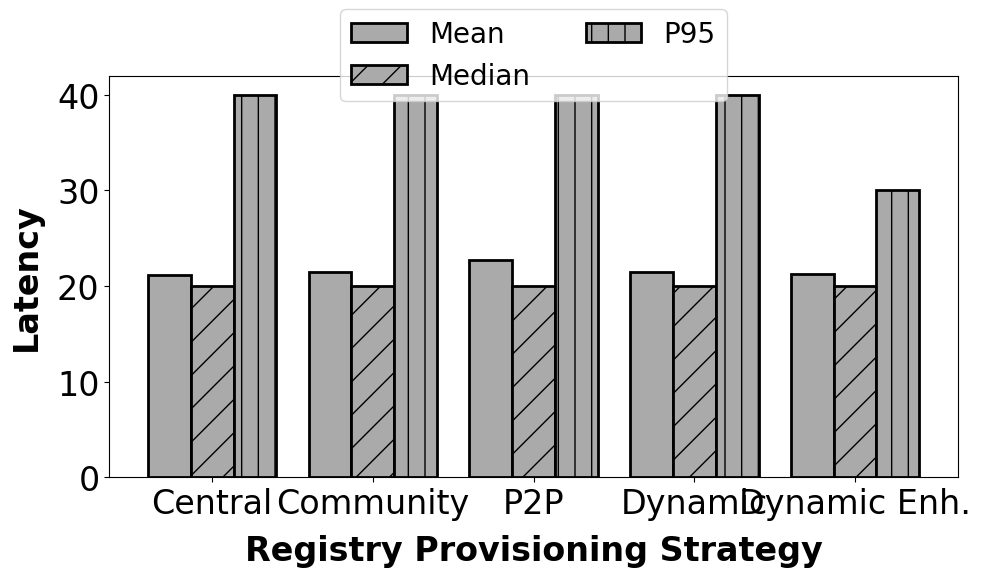

In [16]:
plot_data_with_grouped_bar(
    ["mean", "median", "p95"],
    latency_df,
    "Registry Provisioning Strategy",
    "Latency",
    (0.5, 1.2)
)

### Provisioning Time

In [17]:
provisioning_time_df = get_provisioning_time_data(last_step)

In [18]:
provisioning_time_df

,dataset,mean,median,p95,mean (w/o cache),geo_mean (w/o cache),old_mean
0,"(central, central;nodes=100)",7.680089,4.0,24.00,14.127572,11.637348,9.726081
1,"(community, community;nodes=100)",5.839450,0.0,23.00,13.191710,10.807387,7.186148
2,"(p2p, p2p;nodes=100)",5.114078,3.0,15.00,9.042918,7.522536,6.870362
3,"(dynamic, p2p;nodes=100)",6.594714,4.0,23.00,12.121457,9.780269,8.551948
4,"(dynamic_enhanced, p2p;nodes=100)",6.792035,4.0,22.45,12.685950,10.093803,8.864822
5,"(resource_aware_dynamic, p2p;nodes=100, 1, 0.5)",6.885584,4.0,23.00,12.331967,9.824695,9.089993
6,"(resource_aware_dynamic, p2p;nodes=100, 1, 0.6)",6.796804,4.0,21.00,12.151020,9.655104,8.886939
7,"(resource_aware_dynamic, p2p;nodes=100, 1, 0.7)",6.170787,4.0,20.80,11.072581,8.839140,8.128556
8,"(resource_aware_dynamic, p2p;nodes=100, 1, 0.8)",5.810934,3.0,19.00,10.901709,8.823968,7.824120
9,"(resource_aware_dynamic, p2p;nodes=100, 1, 0.9)",5.748268,4.0,20.00,10.327801,8.293402,7.120985


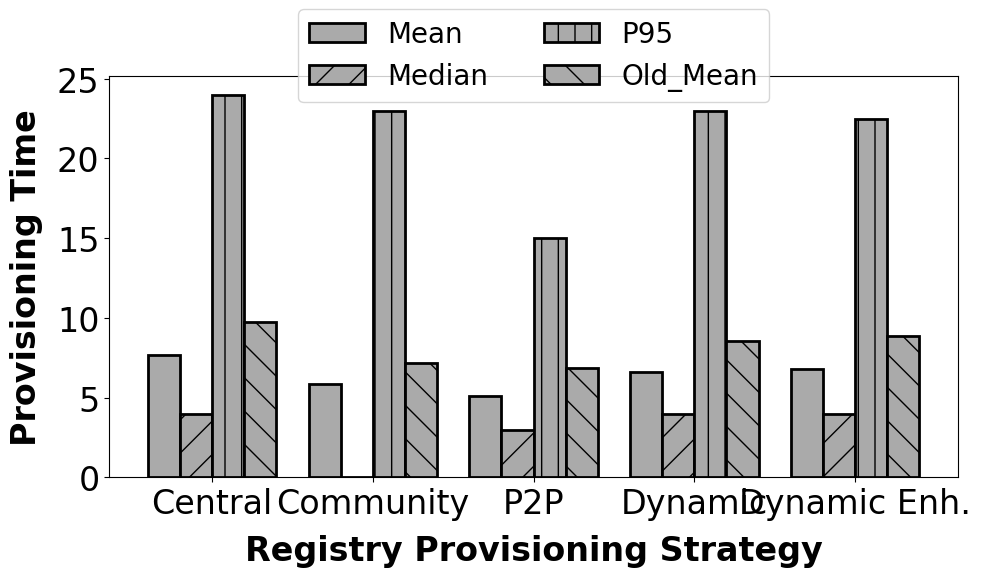

In [19]:
plot_data_with_grouped_bar(
    ["mean", "median", "p95", "old_mean"],
    provisioning_time_df,
    "Registry Provisioning Strategy",
    "Provisioning Time",
    (0.5, 1.2)
)

### Service Reallocations

In [20]:
reallocations_df = get_reallocations_data(last_step)

In [21]:
reallocations_df

,dataset,total,w/o cache
0,"(central, central;nodes=100)",447,243
1,"(community, community;nodes=100)",436,193
2,"(p2p, p2p;nodes=100)",412,233
3,"(dynamic, p2p;nodes=100)",454,247
4,"(dynamic_enhanced, p2p;nodes=100)",452,242
5,"(resource_aware_dynamic, p2p;nodes=100, 1, 0.5)",437,244
6,"(resource_aware_dynamic, p2p;nodes=100, 1, 0.6)",438,245
7,"(resource_aware_dynamic, p2p;nodes=100, 1, 0.7)",445,248
8,"(resource_aware_dynamic, p2p;nodes=100, 1, 0.8)",439,234
9,"(resource_aware_dynamic, p2p;nodes=100, 1, 0.9)",433,241


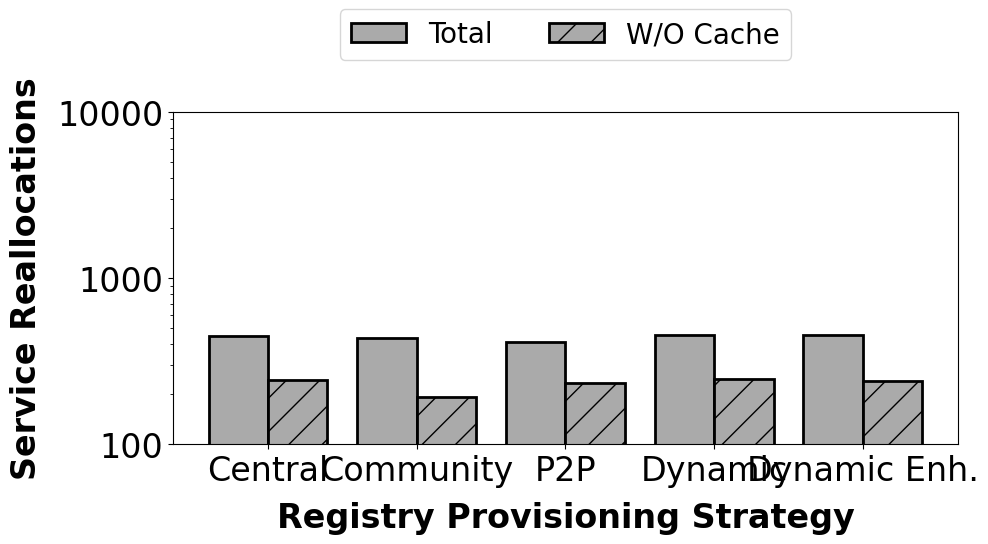

In [22]:
plot_data_with_grouped_bar(
    ["total", "w/o cache"],
    reallocations_df,
    "Registry Provisioning Strategy",
    "Service Reallocations",
    (0.5, 1.35),
    "log",
    [100, 1000, 10000]
)

### Registry Usage

In [23]:
registry_usage_df = get_registry_usage_data()

In [24]:
registry_usage_df

,dataset,mean,median,p95
0,"(central, central;nodes=100)",0.562899,0.562899,0.562899
1,"(community, community;nodes=100)",0.093400,0.082061,0.173424
2,"(p2p, p2p;nodes=100)",0.029341,0.022910,0.049148
3,"(dynamic, p2p;nodes=100)",0.086009,0.050000,0.281556
4,"(dynamic_enhanced, p2p;nodes=100)",0.074577,0.046595,0.278125
5,"(resource_aware_dynamic, p2p;nodes=100, 1, 0.5)",0.074788,0.048473,0.216667
6,"(resource_aware_dynamic, p2p;nodes=100, 1, 0.6)",0.079718,0.062917,0.241667
7,"(resource_aware_dynamic, p2p;nodes=100, 1, 0.7)",0.062737,0.051667,0.160992
8,"(resource_aware_dynamic, p2p;nodes=100, 1, 0.8)",0.066319,0.048333,0.222667
9,"(resource_aware_dynamic, p2p;nodes=100, 1, 0.9)",0.050196,0.037500,0.184583


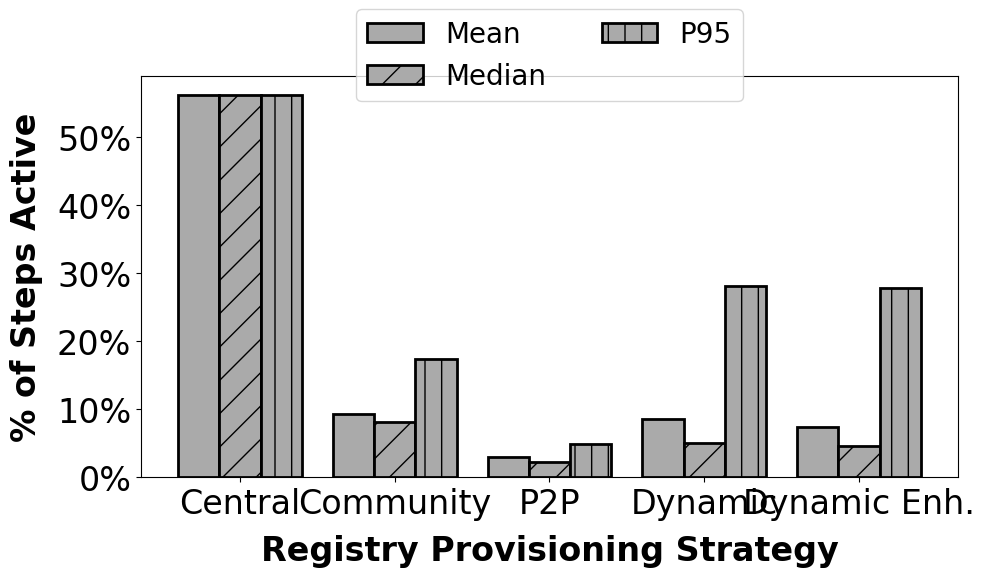

In [25]:
plot_data_with_grouped_bar(
    ["mean", "median", "p95"],
    registry_usage_df,
    "Registry Provisioning Strategy",
    "% of Steps Active",
    (0.5, 1.2),
)

### Number of Registries per Time Step

In [26]:
number_of_registries_df = get_number_of_registries_data()

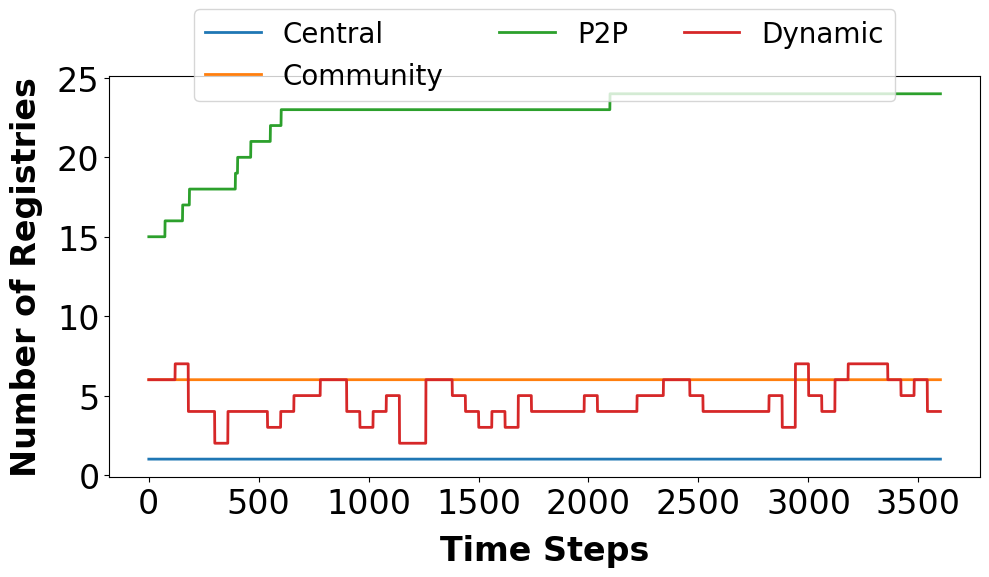

In [27]:
plot_data_over_time(
    labels,
    number_of_registries_df,
    "Time Steps",
    "Number of Registries",
    (0.5, 1.2)
)

### Server Utilization per Time Step

In [28]:
server_utilization_df = get_server_utilization_data()

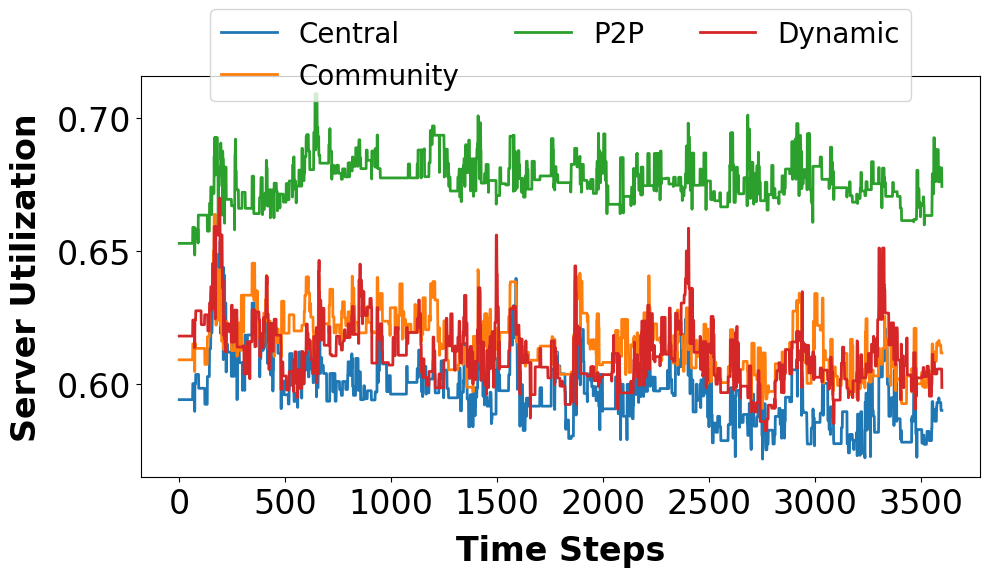

In [29]:
plot_data_over_time(
    labels,
    server_utilization_df,
    "Time Steps",
    "Server Utilization",
    (0.5, 1.2)
)

### Provisioning Time per Time Step

In [30]:
provisioning_time_per_time_step_df = get_provisioning_time_per_time_step_data()

/tmp/ipykernel_450866/4206513679.py:16: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  prov_time_per_timestep = service_df[service_df["Time Step"] > 0].groupby(["Time Step"])["Migrations Duration"].apply(sum).apply(lambda x: sum(x) / len(x) if len(x) > 0 else 0)


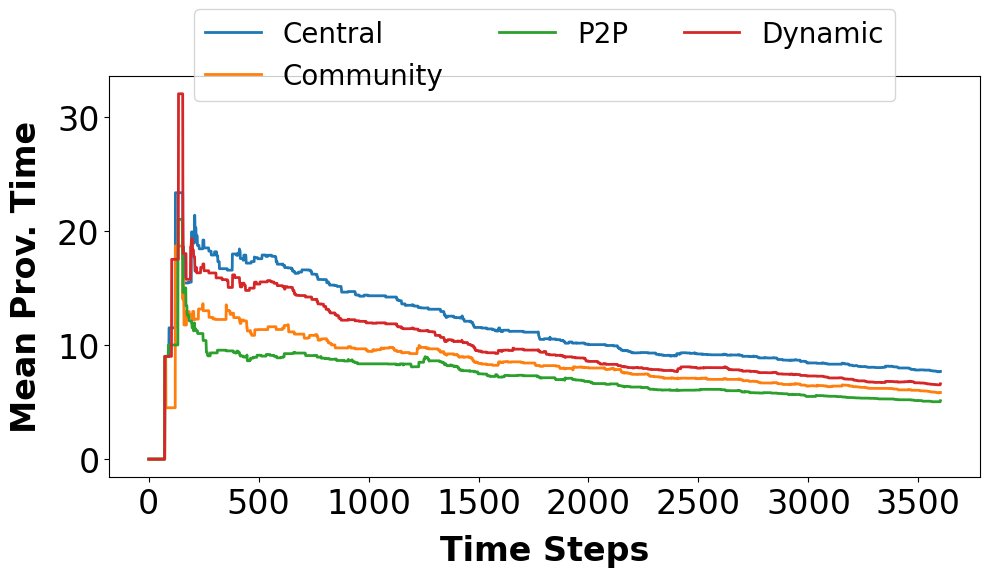

In [31]:
plot_data_over_time(
    labels,
    provisioning_time_per_time_step_df,
    "Time Steps",
    "Mean Prov. Time",
    (0.5, 1.2)
)

### Service Reallocations per Time Step

#### Total

In [32]:
total_service_reallocations_per_timestep_df = get_service_reallocations_per_time_step_data(wo_cache=False)

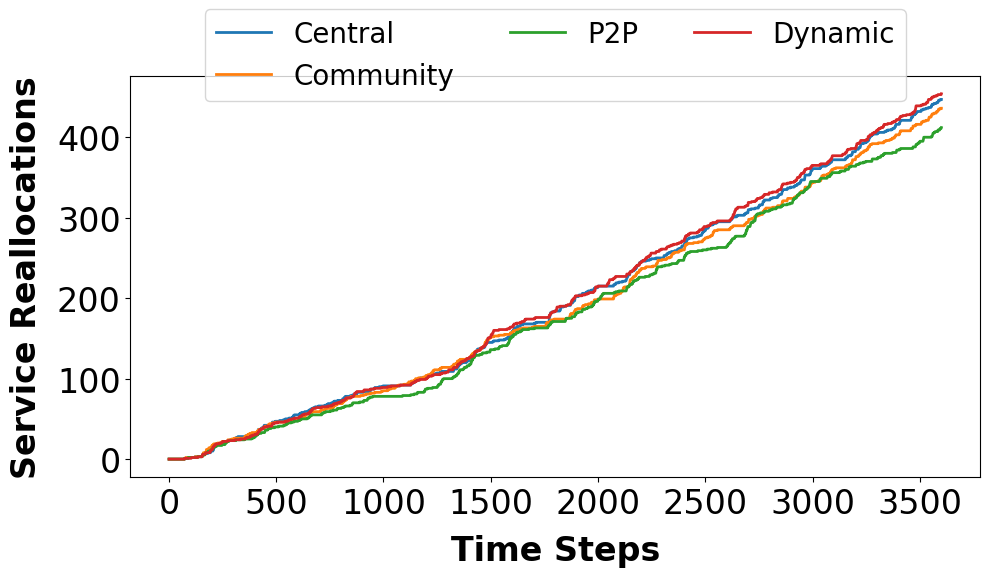

In [33]:
plot_data_over_time(
    labels,
    total_service_reallocations_per_timestep_df,
    "Time Steps",
    "Service Reallocations",
    (0.5, 1.2)
)

#### Without Cache

In [34]:
service_reallocations_wo_cache_per_timestep_df = get_service_reallocations_per_time_step_data(wo_cache=True)

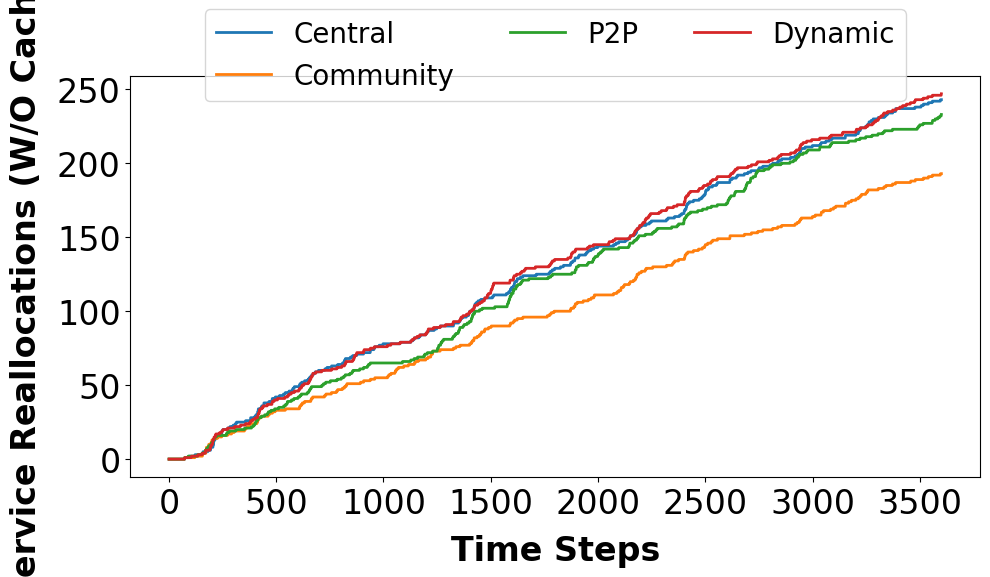

In [35]:
plot_data_over_time(
    labels,
    service_reallocations_wo_cache_per_timestep_df,
    "Time Steps",
    "Service Reallocations (W/O Cache)",
    (0.5, 1.2)
)

### Latency per Time Step

In [36]:
latency_per_time_step_df = get_latency_per_time_step_data()

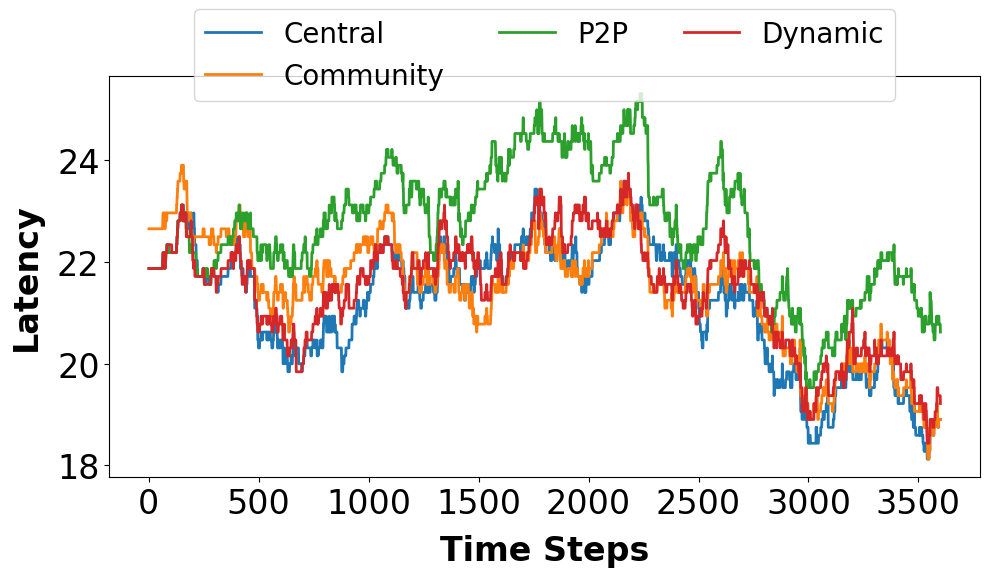

In [37]:
plot_data_over_time(
    labels,
    latency_per_time_step_df,
    "Time Steps",
    "Latency",
    (0.5, 1.2)
)

### Cost Function

In [38]:
cost_function_df = pd.concat([latency_df["dataset"], latency_df["mean"], provisioning_time_df["mean"]], axis=1, keys=["Dataset", "Latency", "Provisioning Time"])

In [39]:
# testing different weights for the cost function
weights = np.arange(0, 1.1, 0.1)
cost_function_data = []

for weight in weights:
    cost_function_df["Cost"] = cost_function_df["Latency"] * weight + cost_function_df["Provisioning Time"] * (1 - weight)
    print(f"Weight: {weight}")
    print(cost_function_df.sort_values(by=["Cost"])[["Dataset", "Cost"]])
    

Weight: 0.0
                                            Dataset      Cost
2                              (p2p, p2p;nodes=100)  5.114078
19  (resource_aware_dynamic, p2p;nodes=100, 3, 0.7)  5.216279
22  (resource_aware_dynamic, p2p;nodes=100, 3, 1.0)  5.240566
16  (resource_aware_dynamic, p2p;nodes=100, 2, 1.0)  5.240566
10  (resource_aware_dynamic, p2p;nodes=100, 1, 1.0)  5.240566
21  (resource_aware_dynamic, p2p;nodes=100, 3, 0.9)  5.247706
20  (resource_aware_dynamic, p2p;nodes=100, 3, 0.8)  5.345708
15  (resource_aware_dynamic, p2p;nodes=100, 2, 0.9)  5.355609
14  (resource_aware_dynamic, p2p;nodes=100, 2, 0.8)  5.401848
18  (resource_aware_dynamic, p2p;nodes=100, 3, 0.6)  5.426230
17  (resource_aware_dynamic, p2p;nodes=100, 3, 0.5)  5.450000
13  (resource_aware_dynamic, p2p;nodes=100, 2, 0.7)  5.462617
9   (resource_aware_dynamic, p2p;nodes=100, 1, 0.9)  5.748268
12  (resource_aware_dynamic, p2p;nodes=100, 2, 0.6)  5.798611
8   (resource_aware_dynamic, p2p;nodes=100, 1, 0.8)  5.810

### Checking Coordinates Trace

In [42]:
labels = ["Central", "Community", "P2P", "Dynamic", "Dynamic Enhanced", "1/0.5", "1/0.6", "1/0.7", "1/0.8", "1/0.9", "1/1.0", "2/0.5", "2/0.6", "2/0.7", "2/0.8", "2/0.9", "2/1.0", "3/0.5", "3/0.6", "3/0.7", "3/0.8", "3/0.9", "3/1.0"]

def get_coordinates_trace_data():
    user_data = {}

    random_user_id = None

    for index, log in enumerate(logs):
        # Opening file
        user_msgpack_file = (
            f"{base_dir}/algorithm={log[0]};dataset={log[1]};seed={seed}/User.msgpack"
            if len (log) == 2
            else f"{base_dir}/algorithm={log[0]};dataset={log[1]};seed={seed};replicas={log[2]};percentage={log[3]}/User.msgpack"
        )
        user_file = open(user_msgpack_file, "rb")
        user_msgpack = msgpack.load(user_file)
        user_df = pd.DataFrame(user_msgpack)

        # Getting random user id
        if random_user_id is None:
            random_user_id = user_df["Object"].sample().iloc[0]

        # Collecting information
        coordinates_trace = user_df[user_df["Object"] == random_user_id][["Coordinates"]]

        # Persisting information
        user_data[f"{labels[index].capitalize()} (User {random_user_id})"] = coordinates_trace

        # Closing file
        user_file.close()

    coordinates_trace_df = pd.concat(user_data, axis=1)

    return coordinates_trace_df   

In [43]:
coordinates_trace_df = get_coordinates_trace_data()

In [44]:
# check if the coordinates are the same for all algorithms
coordinates_are_the_same = True
for i in range(len(coordinates_trace_df.columns) - 1):
    if not coordinates_trace_df.iloc[:, i].equals(coordinates_trace_df.iloc[:, i + 1]):
        coordinates_are_the_same = False
        break

if coordinates_are_the_same:
    print("Coordinates are the same for all algorithms")
else:
    print("Coordinates are not the same for all algorithms")

Coordinates are the same for all algorithms
